# Membership Inference Attack on Decision Tree (MNIST)

## 1. Imports and configurations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, average_precision_score

In [2]:
RANDOM_SEED = 42
N_SHADOW = 5000   # size of shadow set
N_TARGET = 5000   # size of target set
TEST_RATIO = 0.2
ATTACK_MODEL_TYPE = 'logistic'

assert N_SHADOW + N_TARGET <= 70000, "Total samples must not exceed 70000"

np.random.seed(RANDOM_SEED)

## 2. Load and Prepare MNIST Dataset

In [3]:
print("Loading MNIST...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X_full = mnist.data.astype(np.float32) / 255.0
y_full = mnist.target.astype(np.int64)

Loading MNIST...


Split the dataset

In [4]:
total_idx = np.random.permutation(len(X_full))
# shadow and target sets should be non-overlapping
shadow_idx = total_idx[:N_SHADOW]
target_idx = total_idx[N_SHADOW:N_SHADOW + N_TARGET]

X_shadow, y_shadow = X_full[shadow_idx], y_full[shadow_idx]
X_target, y_target = X_full[target_idx], y_full[target_idx]

X_shadow_train, X_shadow_test, y_shadow_train, y_shadow_test = train_test_split(
    X_shadow, y_shadow, test_size=TEST_RATIO, random_state=RANDOM_SEED
)
X_target_train, X_target_test, y_target_train, y_target_test = train_test_split(
    X_target, y_target, test_size=TEST_RATIO, random_state=RANDOM_SEED
)

print(f"Shadow set: {X_shadow_train.shape[0]} training, {X_shadow_test.shape[0]} testing")
print(f"Target set: {X_target_train.shape[0]} training, {X_target_test.shape[0]} testing")

Shadow set: 4000 training, 1000 testing
Target set: 4000 training, 1000 testing


## 3. Select Models and Train Target and Shadow Models


In [5]:
shadow_model = DecisionTreeClassifier(random_state=RANDOM_SEED, max_depth=10)
shadow_model.fit(X_shadow_train, y_shadow_train)

target_model = DecisionTreeClassifier(random_state=RANDOM_SEED, max_depth=10)
target_model.fit(X_target_train, y_target_train)

print("Shadow model accuracy (train):", accuracy_score(y_shadow_train, shadow_model.predict(X_shadow_train)))
print("Shadow model accuracy (test):", accuracy_score(y_shadow_test, shadow_model.predict(X_shadow_test)))
print("Target model accuracy (train):", accuracy_score(y_target_train, target_model.predict(X_target_train)))
print("Target model accuracy (test):", accuracy_score(y_target_test, target_model.predict(X_target_test)))

Shadow model accuracy (train): 0.96425
Shadow model accuracy (test): 0.763
Target model accuracy (train): 0.965
Target model accuracy (test): 0.779


## 4. Construct Attack Model Training Data

In [6]:
def extract_attack_features(proba, mode="all"):
    max_prob = np.max(proba, axis=1, keepdims=True)
    entropy = -np.sum(proba * np.log(proba + 1e-12), axis=1, keepdims=True)
    sorted_proba = np.sort(proba, axis=1)
    margin = (sorted_proba[:,-1] - sorted_proba[:,-2]).reshape(-1,1)

    if mode == "all":
        features = np.hstack([proba, max_prob, entropy, margin])
    elif mode == "maxprob": # prob of most confident class for a sample
        features = max_prob
    elif mode == "entropy": # uncertainty of outputing a prob dist
        features = entropy
    elif mode == "margin": # distance of the largest and the 2nd largest prob
        features = margin
    else:
        raise NotImplementedError
    return features

def get_attack_samples(model, X, label):
    proba = model.predict_proba(X)
    y = np.ones(X.shape[0]) if label == 1 else np.zeros(X.shape[0]) # in=1, out=0
    features = extract_attack_features(proba)
    # returns attack samples: (predict_proba output, member_label)
    return features, y

# shadow model members/non-members
X_attack_in, y_attack_in = get_attack_samples(shadow_model, X_shadow_train, 1)
X_attack_out, y_attack_out = get_attack_samples(shadow_model, X_shadow_test, 0)
X_attack = np.vstack([X_attack_in, X_attack_out])
y_attack = np.concatenate([y_attack_in, y_attack_out])

# target model members/non-members for evaluate the attack model
X_attack_target_in, y_attack_target_in = get_attack_samples(target_model, X_target_train, 1)
X_attack_target_out, y_attack_target_out = get_attack_samples(target_model, X_target_test, 0)
X_attack_eval = np.vstack([X_attack_target_in, X_attack_target_out])
y_attack_eval = np.concatenate([y_attack_target_in, y_attack_target_out])

# normalizing
scaler = StandardScaler()
X_attack = scaler.fit_transform(X_attack)
X_attack_eval = scaler.transform(X_attack_eval)

## 5. Train Attack Model

In [7]:
def get_attack_model(model_type, input_dim, random_state=RANDOM_SEED):
    if model_type == 'mlp':
        return MLPClassifier(hidden_layer_sizes=(128,64,32,), activation='relu', max_iter=100, random_state=random_state)
    elif model_type == 'logistic':
        return LogisticRegression(solver='lbfgs', max_iter=200, random_state=random_state, class_weight='balanced')
    elif model_type == 'svm':
        return SVC(probability=True, kernel='rbf', random_state=RANDOM_SEED, class_weight='balanced')
    elif model_type == 'rf':
        return RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, class_weight='balanced')
    elif model_type == 'knn':
        return KNeighborsClassifier(n_neighbors=5)
    elif model_type == 'dt':
        return DecisionTreeClassifier(random_state=random_state, max_depth=10)
    else:
        raise NotImplementedError("Model type not implemented")

attack_model = get_attack_model(ATTACK_MODEL_TYPE, X_attack.shape[1], RANDOM_SEED)
attack_model.fit(X_attack, y_attack)

print(f"\nAttack model ({ATTACK_MODEL_TYPE}) trained.")


Attack model (logistic) trained.


## 6. Evaluate Attack

In [8]:
def evaluate_attack_model(model, X_eval, y_eval, model_name="Attack Model"):
    y_pred = model.predict(X_eval) # predict class for each sample (member/non-member) using the attack model
    # check if predict_proba exists for current model, if yes then output prob for output being members otherwise y_pred as score (svm, knn)
    y_score = model.predict_proba(X_eval)[:,1] if hasattr(model, "predict_proba") else y_pred
    # evaluation metrics
    acc = accuracy_score(y_eval, y_pred)
    prec = precision_score(y_eval, y_pred)
    rec = recall_score(y_eval, y_pred)
    f1 = f1_score(y_eval, y_pred)
    auc = roc_auc_score(y_eval, y_score) # 0.5 random guess, 1 perfect
    ap = average_precision_score(y_eval, y_score)
    cm = confusion_matrix(y_eval, y_pred)
    fpr, tpr, _ = roc_curve(y_eval, y_score)
    prc, recs, _ = precision_recall_curve(y_eval, y_score)

    print(f"\n{model_name} Attack Model Evaluation:")
    print(f"Accuracy:  {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall:    {rec:.3f}")
    print(f"F1:        {f1:.3f}")
    print(f"AUC:       {auc:.3f}")
    print(f"AvgPrec:   {ap:.3f}")
    print("Confusion Matrix:\n", cm)

    return dict(acc=acc, prec=prec, rec=rec, f1=f1, auc=auc, ap=ap, cm=cm, y_pred=y_pred, y_score=y_score)

attack_eval = evaluate_attack_model(attack_model, X_attack_eval, y_attack_eval, model_name=ATTACK_MODEL_TYPE.upper())


LOGISTIC Attack Model Evaluation:
Accuracy:  0.554
Precision: 0.801
Recall:    0.588
F1:        0.678
AUC:       0.501
AvgPrec:   0.800
Confusion Matrix:
 [[ 416  584]
 [1647 2353]]


## 7. Visualization

In [9]:
def plot_all_attack_metrics(y_true, y_pred, y_score, model_name="Attack Model"):
    from matplotlib import gridspec

    fig = plt.figure(figsize=(18, 5))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])

    # ROC Curve
    ax0 = plt.subplot(gs[0])
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_val = roc_auc_score(y_true, y_score)
    ax0.plot(fpr, tpr, label=f'AUC={auc_val:.2f}')
    ax0.plot([0, 1], [0, 1], '--', color='gray', label='Random')
    ax0.set_xlabel("False Positive Rate")
    ax0.set_ylabel("True Positive Rate")
    ax0.set_title("ROC Curve")
    ax0.legend()
    ax0.grid(True)

    # PR Curve
    ax1 = plt.subplot(gs[1])
    precisions, recalls, _ = precision_recall_curve(y_true, y_score)
    ap_val = average_precision_score(y_true, y_score)
    ax1.plot(recalls, precisions, label=f'AP={ap_val:.2f}')
    ax1.set_xlabel("Recall")
    ax1.set_ylabel("Precision")
    ax1.set_title("Precision-Recall Curve")
    ax1.legend()
    ax1.grid(True)

    # Confusion Matrix
    ax2 = plt.subplot(gs[2])
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-member', 'Member'],
                yticklabels=['Non-member', 'Member'],
                ax=ax2)
    ax2.set_title("Confusion Matrix")
    ax2.set_ylabel("True label")
    ax2.set_xlabel("Predicted")

    fig.suptitle(f"{model_name}: Attack Model Performance", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def plot_score_histogram(y_score, y_true, model_name="Attack Model"):
    plt.figure(figsize=(7,5))
    plt.hist(y_score[np.array(y_true)==1], bins=50, alpha=0.7, label='Member', color='orange')
    plt.hist(y_score[np.array(y_true)==0], bins=50, alpha=0.7, label='Non-member', color='blue')
    plt.xlabel("Predicted member probability")
    plt.ylabel("Count")
    plt.title(f"Score Distribution: {model_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

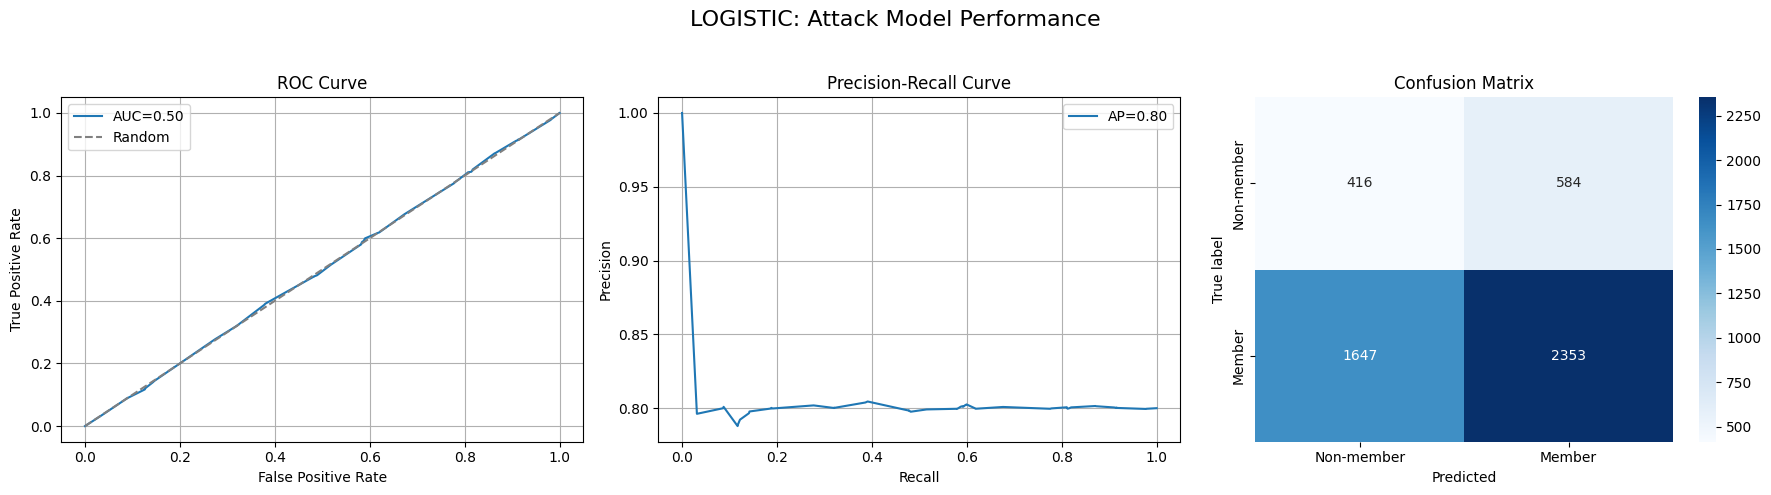

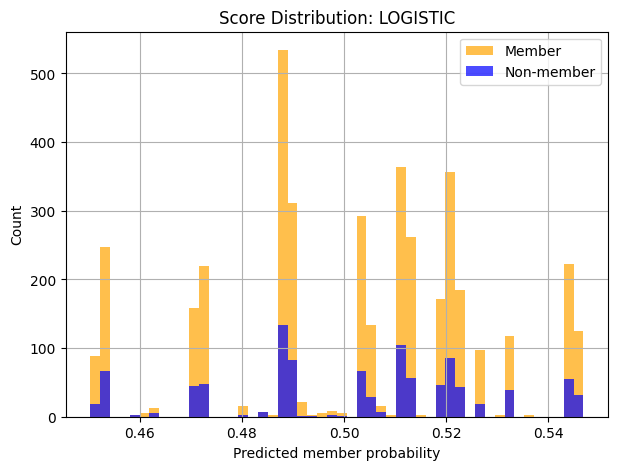

In [10]:
plot_all_attack_metrics(y_attack_eval, attack_eval['y_pred'], attack_eval['y_score'], model_name=ATTACK_MODEL_TYPE.upper())
plot_score_histogram(attack_eval['y_score'], y_attack_eval, model_name=ATTACK_MODEL_TYPE.upper())

# Extra: Ablation

In [11]:
def plot_attack_summary(y_true, y_score, y_pred, mode_name="Feature"):
    fig, axes = plt.subplots(1, 4, figsize=(20, 4))

    # ROC
    from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, confusion_matrix
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)
    axes[0].plot(fpr, tpr, label=f'AUC={auc:.2f}')
    axes[0].plot([0, 1], [0, 1], '--', color='gray', label='Random')
    axes[0].set_xlabel('FPR')
    axes[0].set_ylabel('TPR')
    axes[0].set_title('ROC')
    axes[0].legend()

    # PRC
    precisions, recalls, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    axes[1].plot(recalls, precisions, label=f'AP={ap:.2f}')
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title('PRC')
    axes[1].legend()

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[2],
                xticklabels=['Non-member', 'Member'],
                yticklabels=['Non-member', 'Member'])
    axes[2].set_title('Confusion Matrix')

    # histogram
    axes[3].hist(y_score[y_true == 1], bins=30, alpha=0.7, label='Member')
    axes[3].hist(y_score[y_true == 0], bins=30, alpha=0.7, label='Non-member')
    axes[3].set_xlabel('Predicted member probability')
    axes[3].set_ylabel('Count')
    axes[3].legend()
    axes[3].set_title('Score Distribution')

    plt.suptitle(f'Attack Model Performance ({mode_name})')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


all Attack Model Evaluation:
Accuracy:  0.555
Precision: 0.801
Recall:    0.591
F1:        0.680
AUC:       0.501
AvgPrec:   0.800
Confusion Matrix:
 [[ 413  587]
 [1637 2363]]


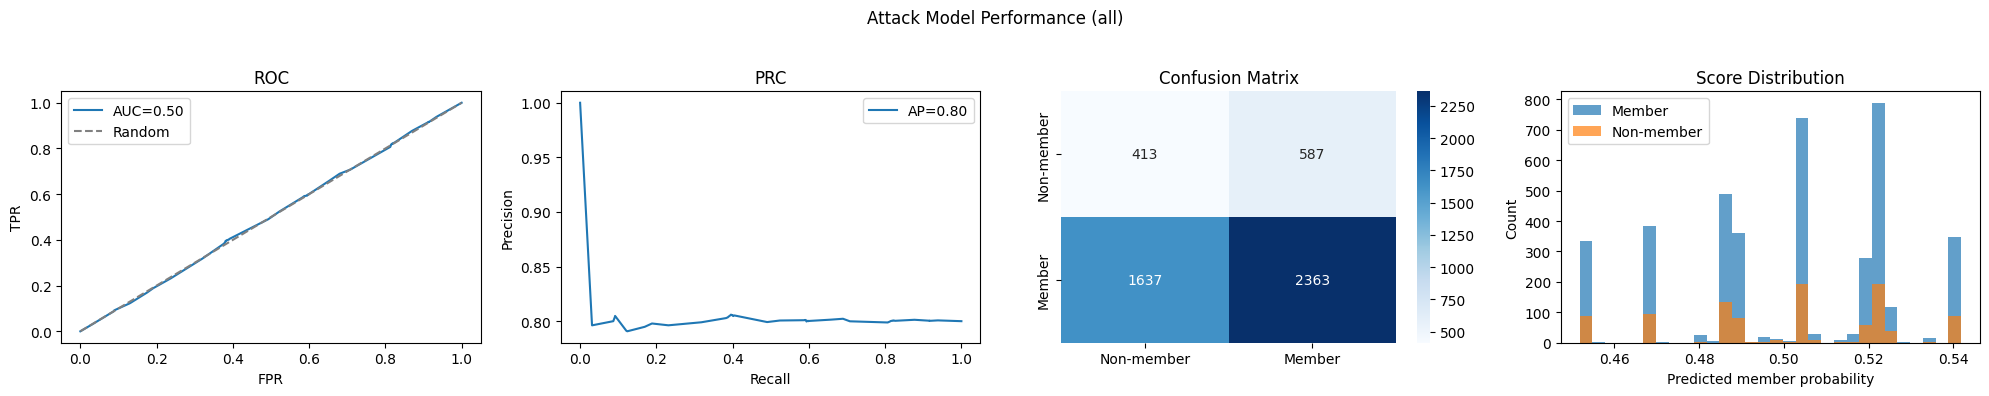

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



maxprob Attack Model Evaluation:
Accuracy:  0.200
Precision: 0.000
Recall:    0.000
F1:        0.000
AUC:       0.500
AvgPrec:   0.800
Confusion Matrix:
 [[1000    0]
 [4000    0]]


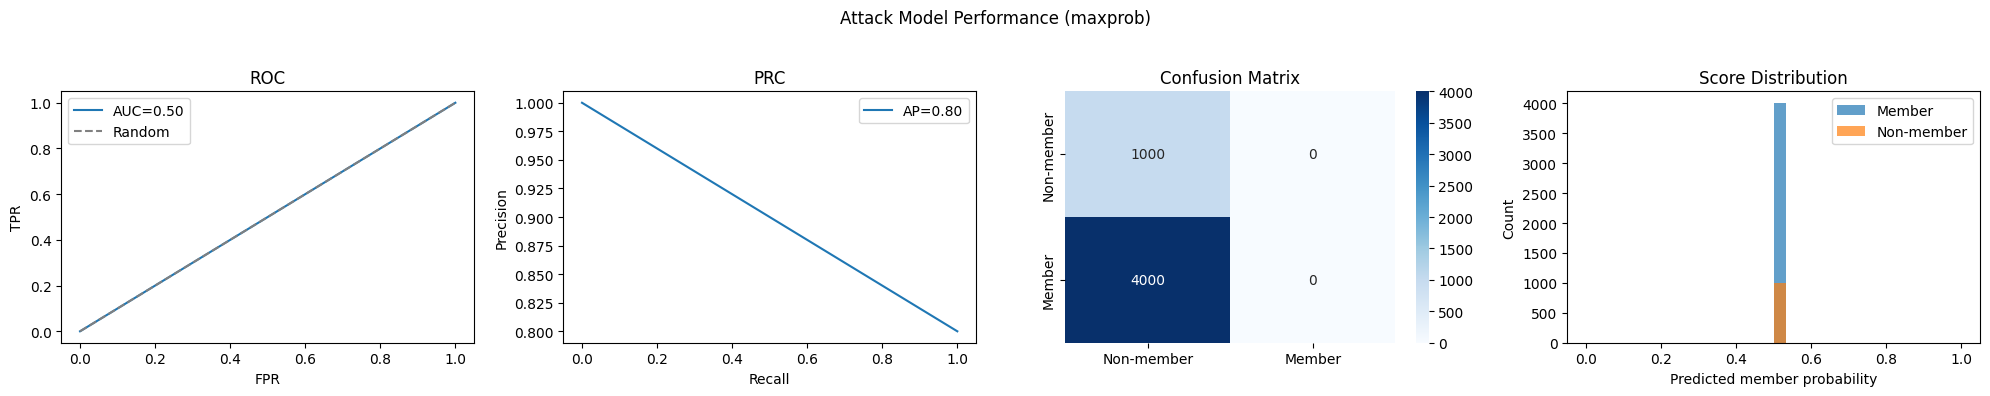


entropy Attack Model Evaluation:
Accuracy:  0.333
Precision: 0.820
Recall:    0.212
F1:        0.338
AUC:       0.516
AvgPrec:   0.810
Confusion Matrix:
 [[ 813  187]
 [3150  850]]


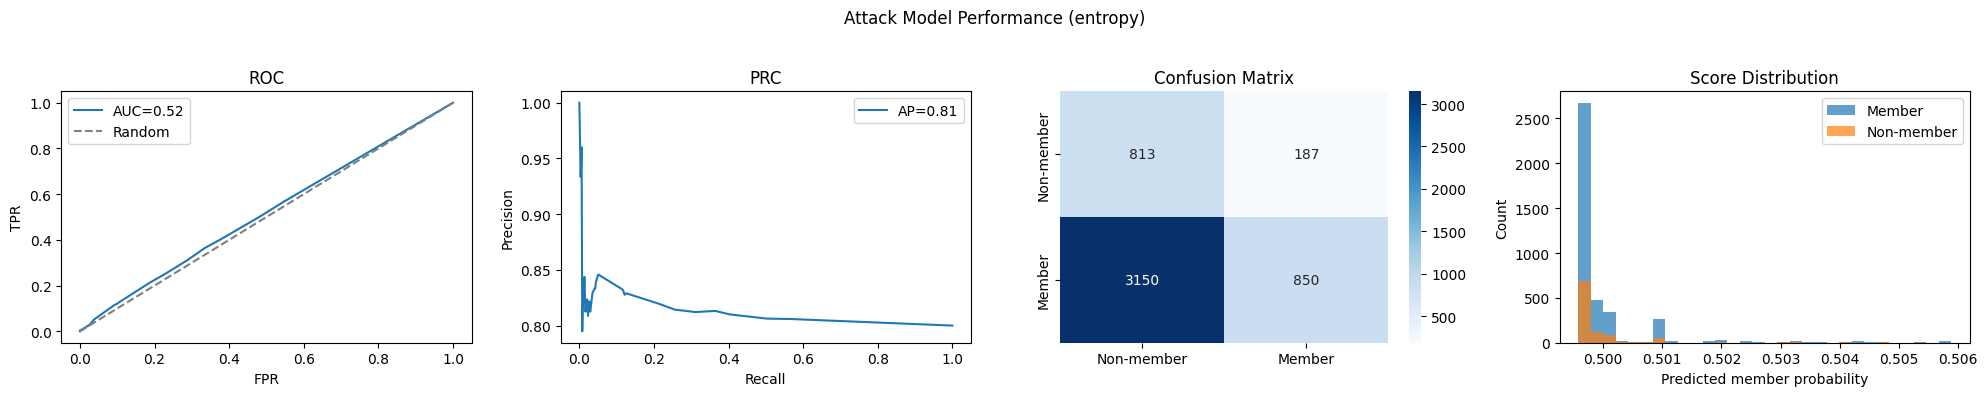

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



margin Attack Model Evaluation:
Accuracy:  0.200
Precision: 0.000
Recall:    0.000
F1:        0.000
AUC:       0.500
AvgPrec:   0.800
Confusion Matrix:
 [[1000    0]
 [4000    0]]


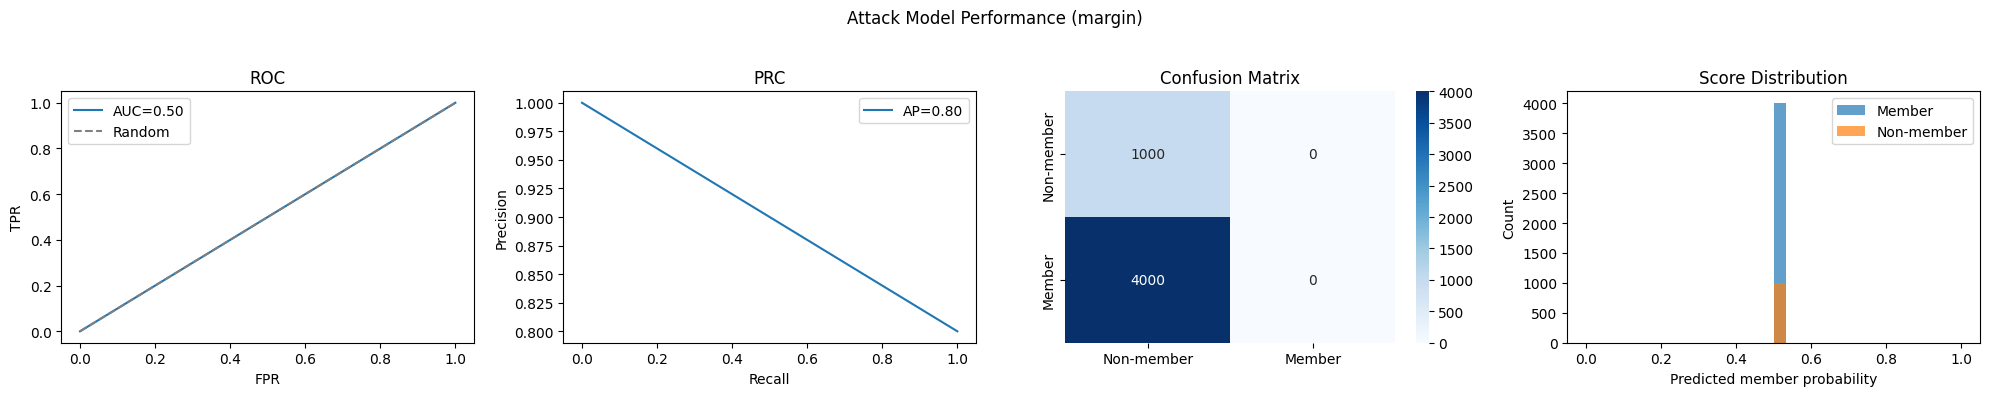

In [12]:
for mode in ["all", "maxprob", "entropy", "margin"]:
    X_attack_feat = np.vstack([
        extract_attack_features(shadow_model.predict_proba(X_shadow_train), mode),
        extract_attack_features(shadow_model.predict_proba(X_shadow_test), mode)
    ])
    y_attack_feat = np.concatenate([np.ones(len(X_shadow_train)), np.zeros(len(X_shadow_test))])
    X_attack_eval_feat = np.vstack([
        extract_attack_features(target_model.predict_proba(X_target_train), mode),
        extract_attack_features(target_model.predict_proba(X_target_test), mode)
    ])
    y_attack_eval_feat = np.concatenate([np.ones(len(X_target_train)), np.zeros(len(X_target_test))])

    attack_model = get_attack_model('logistic', X_attack_feat.shape[1], RANDOM_SEED)
    attack_model.fit(X_attack_feat, y_attack_feat)

    # get predictions and score
    y_pred = attack_model.predict(X_attack_eval_feat)
    if hasattr(attack_model, "predict_proba"):
        y_score = attack_model.predict_proba(X_attack_eval_feat)[:, 1]
    else:
        y_score = y_pred

    evaluate_attack_model(attack_model, X_attack_eval_feat, y_attack_eval_feat, model_name=f"{mode}")

    # visualization
    plot_attack_summary(y_attack_eval_feat, y_score, y_pred, mode_name=mode)

# Extra: Attack Models Comparison

In [13]:
model_types = ['logistic', 'mlp', 'svm', 'rf', 'knn']
results = {}

for mt in model_types:
    attack_model = get_attack_model(mt, X_attack.shape[1], RANDOM_SEED)
    attack_model.fit(X_attack, y_attack)
    res = evaluate_attack_model(attack_model, X_attack_eval, y_attack_eval, model_name=mt.upper())
    results[mt] = res

df = pd.DataFrame(results).T
print(df[['acc', 'auc', 'f1', 'ap']])


LOGISTIC Attack Model Evaluation:
Accuracy:  0.554
Precision: 0.801
Recall:    0.588
F1:        0.678
AUC:       0.501
AvgPrec:   0.800
Confusion Matrix:
 [[ 416  584]
 [1647 2353]]

MLP Attack Model Evaluation:
Accuracy:  0.800
Precision: 0.800
Recall:    1.000
F1:        0.889
AUC:       0.515
AvgPrec:   0.808
Confusion Matrix:
 [[   0 1000]
 [   0 4000]]

SVM Attack Model Evaluation:
Accuracy:  0.565
Precision: 0.802
Recall:    0.605
F1:        0.690
AUC:       0.499
AvgPrec:   0.798
Confusion Matrix:
 [[ 402  598]
 [1579 2421]]

RF Attack Model Evaluation:
Accuracy:  0.591
Precision: 0.800
Recall:    0.652
F1:        0.718
AUC:       0.512
AvgPrec:   0.806
Confusion Matrix:
 [[ 350  650]
 [1393 2607]]

KNN Attack Model Evaluation:
Accuracy:  0.800
Precision: 0.800
Recall:    1.000
F1:        0.889
AUC:       0.496
AvgPrec:   0.799
Confusion Matrix:
 [[   0 1000]
 [   0 4000]]
             acc       auc        f1        ap
logistic  0.5538  0.500892  0.678391  0.799756
mlp         

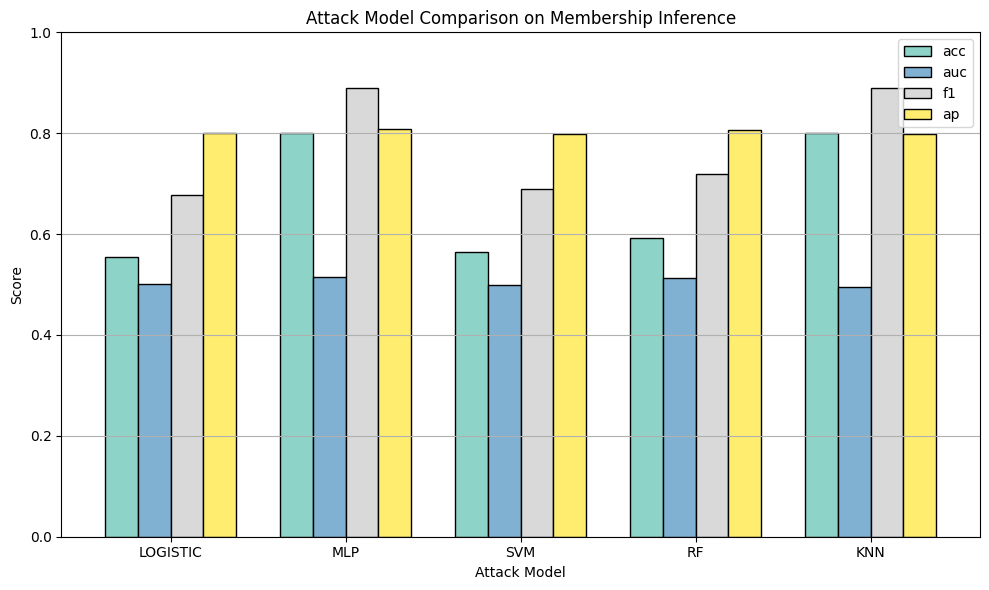

In [14]:
df_plot = df[['acc', 'auc', 'f1', 'ap']]
df_plot.index = [name.upper() for name in df_plot.index]

ax = df_plot.plot(
    kind='bar',
    figsize=(10, 6),
    width=0.75,
    rot=0,
    ylim=(0, 1),
    colormap='Set3',
    edgecolor='black'
)
plt.title('Attack Model Comparison on Membership Inference')
plt.ylabel('Score')
plt.xlabel('Attack Model')
plt.legend(loc='upper right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Extra: Size of datasets

In [15]:
sizes = [2000, 5000, 10000, 20000, 30000]
results_size = []

for N in sizes:
    print(f"=== Running for SHADOW={N}, TARGET={N} ===")
    total_idx = np.random.permutation(len(X_full))
    shadow_idx = total_idx[:N]
    target_idx = total_idx[N:N+N]
    X_shadow, y_shadow = X_full[shadow_idx], y_full[shadow_idx]
    X_target, y_target = X_full[target_idx], y_full[target_idx]

    X_shadow_train, X_shadow_test, y_shadow_train, y_shadow_test = train_test_split(
        X_shadow, y_shadow, test_size=TEST_RATIO, random_state=RANDOM_SEED
    )
    X_target_train, X_target_test, y_target_train, y_target_test = train_test_split(
        X_target, y_target, test_size=TEST_RATIO, random_state=RANDOM_SEED
    )

    shadow_model = DecisionTreeClassifier(random_state=RANDOM_SEED, max_depth=8)
    shadow_model.fit(X_shadow_train, y_shadow_train)
    target_model = DecisionTreeClassifier(random_state=RANDOM_SEED, max_depth=8)
    target_model.fit(X_target_train, y_target_train)
    X_attack_in, y_attack_in = get_attack_samples(shadow_model, X_shadow_train, 1)
    X_attack_out, y_attack_out = get_attack_samples(shadow_model, X_shadow_test, 0)
    X_attack = np.vstack([X_attack_in, X_attack_out])
    y_attack = np.concatenate([y_attack_in, y_attack_out])
    X_attack_target_in, y_attack_target_in = get_attack_samples(target_model, X_target_train, 1)
    X_attack_target_out, y_attack_target_out = get_attack_samples(target_model, X_target_test, 0)
    X_attack_eval = np.vstack([X_attack_target_in, X_attack_target_out])
    y_attack_eval = np.concatenate([y_attack_target_in, y_attack_target_out])

    scaler = StandardScaler()
    X_attack = scaler.fit_transform(X_attack)
    X_attack_eval = scaler.transform(X_attack_eval)

    attack_model = get_attack_model('logistic', X_attack.shape[1], RANDOM_SEED)
    attack_model.fit(X_attack, y_attack)
    res = evaluate_attack_model(attack_model, X_attack_eval, y_attack_eval, model_name=f"logistic_size{N}")
    results_size.append({'size': N, 'acc': res['acc'], 'auc': res['auc'], 'f1': res['f1'], 'ap': res['ap']})

=== Running for SHADOW=2000, TARGET=2000 ===

logistic_size2000 Attack Model Evaluation:
Accuracy:  0.484
Precision: 0.795
Recall:    0.479
F1:        0.598
AUC:       0.491
AvgPrec:   0.790
Confusion Matrix:
 [[203 197]
 [834 766]]
=== Running for SHADOW=5000, TARGET=5000 ===

logistic_size5000 Attack Model Evaluation:
Accuracy:  0.539
Precision: 0.804
Recall:    0.559
F1:        0.660
AUC:       0.506
AvgPrec:   0.800
Confusion Matrix:
 [[ 455  545]
 [1762 2238]]
=== Running for SHADOW=10000, TARGET=10000 ===

logistic_size10000 Attack Model Evaluation:
Accuracy:  0.488
Precision: 0.808
Recall:    0.472
F1:        0.596
AUC:       0.508
AvgPrec:   0.802
Confusion Matrix:
 [[1103  897]
 [4222 3778]]
=== Running for SHADOW=20000, TARGET=20000 ===

logistic_size20000 Attack Model Evaluation:
Accuracy:  0.449
Precision: 0.808
Recall:    0.409
F1:        0.543
AUC:       0.512
AvgPrec:   0.807
Confusion Matrix:
 [[2442 1558]
 [9463 6537]]
=== Running for SHADOW=30000, TARGET=30000 ===

lo

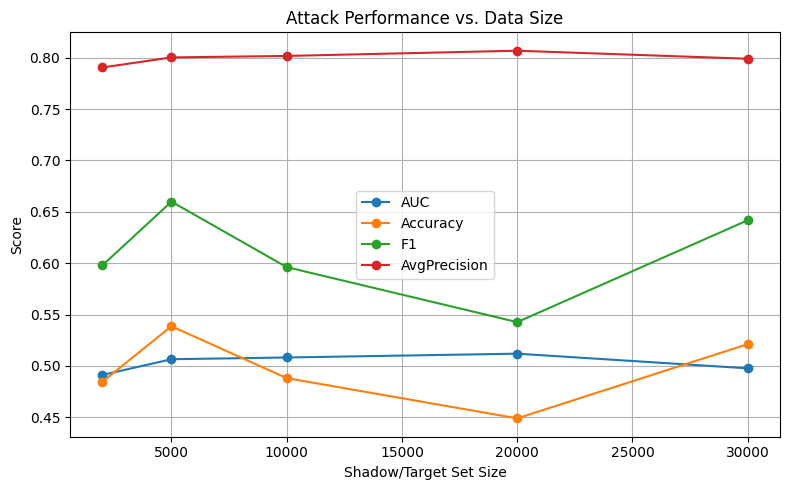

In [16]:
df_size = pd.DataFrame(results_size)
plt.figure(figsize=(8, 5))
plt.plot(df_size['size'], df_size['auc'], marker='o', label='AUC')
plt.plot(df_size['size'], df_size['acc'], marker='o', label='Accuracy')
plt.plot(df_size['size'], df_size['f1'], marker='o', label='F1')
plt.plot(df_size['size'], df_size['ap'], marker='o', label='AvgPrecision')
plt.xlabel('Shadow/Target Set Size')
plt.ylabel('Score')
plt.title('Attack Performance vs. Data Size')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()